# Arash Modaresi Rad

## student ID: 114089286

### Collaborate: Amir Kazemzadeh & Ahmad Hojatimalekshah

# CS534 Homework 4

Put your homework in the directory with your name. Please mentionin this file the names of any students with whom you collaborated. If you didn't collaborate with anyone, mark your collaborators as "None." Remember, your goal is to communicate. Full credit will be given only to correct solutions which are described clearly. Convoluted and obtuse descriptions will receive low marks. To complete your homework, you may ONLY consult the following material:

lecture slides course notes you or others took during lecture. the required text (CLRS) websites that may clarify the concepts covered in the material but do not in any way provide complete solutions to the problems. Deadline 04/27/2020

Please provide an answer to the following question:

In [53]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import model_selection, datasets
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, LabelEncoder
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split , StratifiedKFold, KFold, cross_validate, learning_curve, GridSearchCV
from sklearn.svm import SVC
from sklearn.cluster import DBSCAN, KMeans
from sklearn import metrics
from sklearn.metrics import silhouette_score
from sklearn.metrics.cluster import homogeneity_score
from sklearn.metrics.cluster import completeness_score
from matplotlib.colors import ListedColormap
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

# Question 1 (15 pts)

Implement the ADABoost algorithm by using the scikit implementation of the logistic regression. Evaluate the result on a real dataset between a single logistic regression and AdaBoost (use K-Fold cross validation).

This links can be helpful: http://rob.schapire.net/papers/explaining-adaboost.pdf and https://en.wikipedia.org/wiki/AdaBoost


In [7]:
breast_cancer = datasets.load_breast_cancer()
Data = pd.DataFrame(breast_cancer.data, columns = breast_cancer.feature_names)
Target = pd.Categorical.from_codes(breast_cancer.target, breast_cancer.target_names)
Target_labelencoder = LabelEncoder()
Target = Target_labelencoder.fit_transform(Target)
Data_train, Data_test, Target_train, Target_test = train_test_split(np.array(Data), np.array(Target), test_size = 0.3, random_state = 1000)

In [25]:
def AdaBoost(Data_train, Target_train, folds = 5, M = 10, learning_rate = 1):
    
    #Setup K-folds
    skf = KFold(n_splits = folds, random_state = 1000, shuffle=True )
    acc_train = []
    acc_valid = []
    acc_valid_logistic = []
    
    for train_index, valid_index in skf.split(Data_train, Target_train):
        Data_train_fold = Data_train[train_index]
        Data_valid_fold = Data_train[valid_index]
        Target_train_fold = Target_train[train_index]
        Target_valid_fold = Target_train[valid_index]
        
        #Initialize the sample weights
        Estimator_list = []
        Estimator_error_list = []
        Target_predict_list_train = []
        Target_predict_list_valid = []
        Estimator_weight_list = []
        Sample_weight_list = []
        
        N1 = len(Target_valid_fold)
        N2 = len(Target_train_fold)
        Sample_weight = np.ones(N2) / N2
        Sample_weight_list.append(Sample_weight.copy())
        
        #Training logistic classifier for each fold
        lg_fold = LogisticRegression(random_state = 1000)
        clf = lg_fold.fit(Data_train_fold, Target_train_fold)
        acc_valid_logistic.append(clf.score(Data_valid_fold, Target_valid_fold))
        print('Accuracy for logistic regression of a single fold is: {acc}'.format(acc = clf.score(Data_valid_fold, Target_valid_fold)))

        for m in range(M):
            #Fit a classifier
            Estimator = LogisticRegression()
            Estimator.fit(Data_train_fold, Target_train_fold, sample_weight = Sample_weight)
            Target_predict_train = Estimator.predict(Data_train_fold)
            Target_predict_valid = Estimator.predict(Data_valid_fold)

            #Misclassifications
            Incorrect = (Target_predict_train != Target_train_fold)

            #Estimator error
            Estimator_error = np.mean(np.average(Incorrect, weights = Sample_weight, axis = 0))

            #Boost estimator weights
            Estimator_weight =  learning_rate * np.log((1. - Estimator_error) / Estimator_error)

            #Boost sample weights
            Sample_weight *= np.exp(Estimator_weight * Incorrect * ((Sample_weight > 0) | (Estimator_weight < 0)))

            #Save iteration values
            Estimator_list.append(Estimator)
            Estimator_error_list.append(Estimator_error.copy())
            Target_predict_list_train.append(Target_predict_train.copy())
            Target_predict_list_valid.append(Target_predict_valid.copy())
            Estimator_weight_list.append(Estimator_weight.copy())
            Sample_weight_list.append(Sample_weight.copy())
        
        #Convert to np array for convenience   
        Estimator_list = np.asarray(Estimator_list)
        Estimator_error_list = np.asarray(Estimator_error_list)
        Target_predict_list_train = np.asarray(Target_predict_list_train)
        Target_predict_list_valid = np.asarray(Target_predict_list_valid)
        Estimator_weight_list = np.asarray(Estimator_weight_list)
        Sample_weight_list = np.asarray(Sample_weight_list)
        
        #Predictions
        preds_valid = (np.array([np.sign((Target_predict_list_valid[:,point] * Estimator_weight_list).sum()) for point in range(N1)]))
        acc_valid.append((preds_valid == Target_valid_fold).sum() / N1)
        preds_train = (np.array([np.sign((Target_predict_list_train[:,point] * Estimator_weight_list).sum()) for point in range(N2)]))
        acc_train.append((preds_train == Target_train_fold).sum() / N2)
        print('Accuracy for AdaBoost of a single fold is: {acc}'.format(acc = (preds_valid == Target_valid_fold).sum() / N1))
        print('######################################################################################')
    
    print('######################################################################################')
    print("Accuracy of Training data with AdaBoost: ",np.mean(acc_train))
    print("Accuracy of K-fold cross validation with AdaBoost: ",np.mean(acc_valid))
    print("Accuracy of K-fold cross validation with Logistic regression: ",np.mean(acc_valid_logistic))
    
    return Estimator_list, Estimator_weight_list, Sample_weight_list

Using 10 folds:

In [27]:
Estimator_list, Estimator_weight_list, Sample_weight_list = AdaBoost(Data_train, Target_train, 10, learning_rate = 1)

Accuracy for logistic regression of a single fold is: 0.925
Accuracy for AdaBoost of a single fold is: 0.525
######################################################################################
Accuracy for logistic regression of a single fold is: 0.925
Accuracy for AdaBoost of a single fold is: 0.325
######################################################################################
Accuracy for logistic regression of a single fold is: 0.925
Accuracy for AdaBoost of a single fold is: 0.5
######################################################################################
Accuracy for logistic regression of a single fold is: 0.95
Accuracy for AdaBoost of a single fold is: 0.9
######################################################################################
Accuracy for logistic regression of a single fold is: 0.975
Accuracy for AdaBoost of a single fold is: 0.5
######################################################################################
Accuracy for logistic regre

Using 8 folds:

In [28]:
Estimator_list, Estimator_weight_list, Sample_weight_list = AdaBoost(Data_train, Target_train, 8, learning_rate = 1)

Accuracy for logistic regression of a single fold is: 0.92
Accuracy for AdaBoost of a single fold is: 0.56
######################################################################################
Accuracy for logistic regression of a single fold is: 0.94
Accuracy for AdaBoost of a single fold is: 0.22
######################################################################################
Accuracy for logistic regression of a single fold is: 0.94
Accuracy for AdaBoost of a single fold is: 0.36
######################################################################################
Accuracy for logistic regression of a single fold is: 0.96
Accuracy for AdaBoost of a single fold is: 0.48
######################################################################################
Accuracy for logistic regression of a single fold is: 0.96
Accuracy for AdaBoost of a single fold is: 0.6
######################################################################################
Accuracy for logistic regressio

Using 6 folds:

In [29]:
Estimator_list, Estimator_weight_list, Sample_weight_list = AdaBoost(Data_train, Target_train, 6, learning_rate = 1)

Accuracy for logistic regression of a single fold is: 0.9104477611940298
Accuracy for AdaBoost of a single fold is: 0.8805970149253731
######################################################################################
Accuracy for logistic regression of a single fold is: 0.9402985074626866
Accuracy for AdaBoost of a single fold is: 0.8507462686567164
######################################################################################
Accuracy for logistic regression of a single fold is: 0.9393939393939394
Accuracy for AdaBoost of a single fold is: 0.5757575757575758
######################################################################################
Accuracy for logistic regression of a single fold is: 0.9393939393939394
Accuracy for AdaBoost of a single fold is: 0.8636363636363636
######################################################################################
Accuracy for logistic regression of a single fold is: 0.9545454545454546
Accuracy for AdaBoost of a single fold 

Using 4 folds:

In [32]:
Estimator_list, Estimator_weight_list, Sample_weight_list = AdaBoost(Data_train, Target_train, 4, learning_rate = 1)

Accuracy for logistic regression of a single fold is: 0.93
Accuracy for AdaBoost of a single fold is: 0.35
######################################################################################
Accuracy for logistic regression of a single fold is: 0.94
Accuracy for AdaBoost of a single fold is: 0.91
######################################################################################
Accuracy for logistic regression of a single fold is: 0.9191919191919192
Accuracy for AdaBoost of a single fold is: 0.4444444444444444
######################################################################################
Accuracy for logistic regression of a single fold is: 0.9595959595959596
Accuracy for AdaBoost of a single fold is: 0.37373737373737376
######################################################################################
######################################################################################
Accuracy of Training data with AdaBoost:  0.5211190545666764
Accuracy of K-fold 

Using 2 folds:

In [31]:
Estimator_list, Estimator_weight_list, Sample_weight_list = AdaBoost(Data_train, Target_train, 2, learning_rate = 1)

Accuracy for logistic regression of a single fold is: 0.9396984924623115
Accuracy for AdaBoost of a single fold is: 0.9045226130653267
######################################################################################
Accuracy for logistic regression of a single fold is: 0.9396984924623115
Accuracy for AdaBoost of a single fold is: 0.6633165829145728
######################################################################################
######################################################################################
Accuracy of Training data with AdaBoost:  0.7964824120603016
Accuracy of K-fold cross validation with AdaBoost:  0.7839195979899498
Accuracy of K-fold cross validation with Logistic regression:  0.9396984924623115


`As demonstrated for a number of folds greater than 6 the AdaBoost is overtrained and the best validation accurecy belongs to 2 folds. All in all, the Logistic regression outpreforms the AdaBoosting in this example`

## Question 2 (10 pts)
Use DBscan (try with different parameters) and K-means (K=3) on IRIS Dataset and discuss/compare the results with the iris ground truth.
Please provide an explanation of why K-fold cross validation is not required for the comparison among these different algorithms.

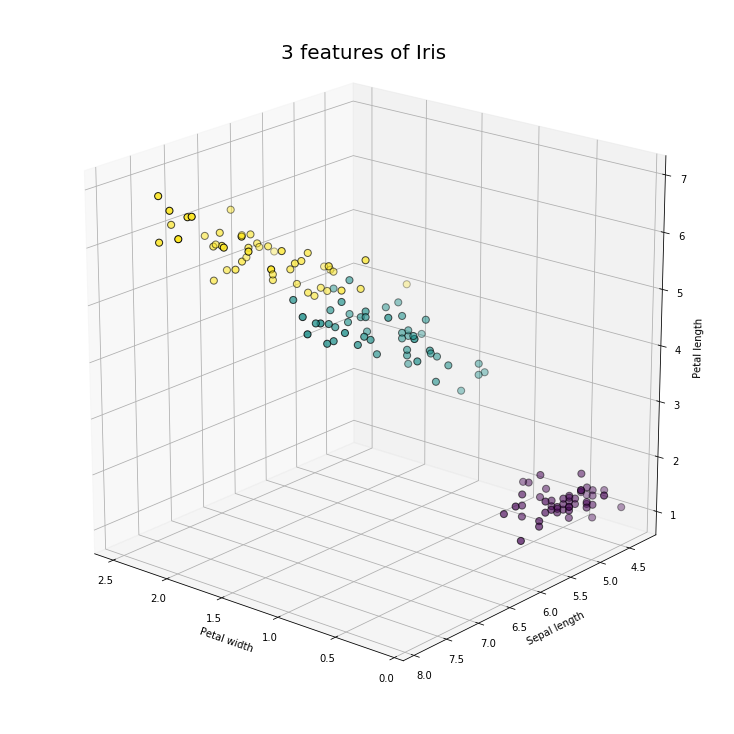

In [39]:
iris = datasets.load_iris()
Data = iris.data
Target = iris.target

fig = plt.figure(1, figsize = (10,10))
ax = Axes3D(fig, rect = [0, 0, 1, 1], elev = 20, azim = 130)
ax.scatter(Data[:, 3], Data[:, 0], Data[:, 2], c = Target, edgecolor = "k", s = 50)
ax.set_xlabel("Petal width")
ax.set_ylabel("Sepal length")
ax.set_zlabel("Petal length")
plt.title("3 features of Iris ", fontsize = 20)
plt.show()

**DBScan**

DbScan with eps = 0.5 and min_samples = 5:

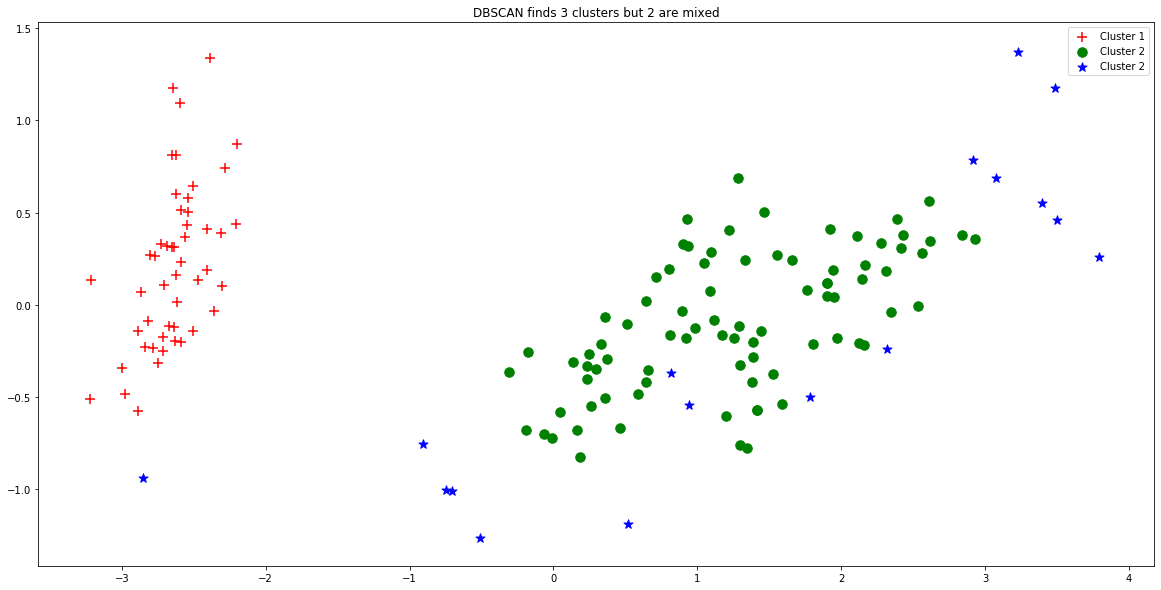

In [69]:
dbscan = DBSCAN()
db = dbscan.fit(Data)
pca = PCA(n_components = 2).fit(Data)
pca_2d = pca.transform(Data)
plt.figure(figsize=(20,10))

for i in range(0, pca_2d.shape[0]):
    if dbscan.labels_[i] == 0:
        c1 = plt.scatter(pca_2d[i, 0], pca_2d[i, 1], s = 90, c='r', marker='+')
    elif dbscan.labels_[i] == 1:
        c2 = plt.scatter(pca_2d[i, 0], pca_2d[i, 1], s = 90, c='g', marker='o')
    elif dbscan.labels_[i] == -1:
        c3 = plt.scatter(pca_2d[i, 0], pca_2d[i, 1], s = 90, c='b', marker='*')


plt.legend([c1, c2, c3], ['Cluster 1', 'Cluster 2', 'Cluster 2'])
plt.title('DBSCAN finds 3 clusters but 2 are mixed')
plt.show()

Now lets look at some scores for DbScan >>

In [70]:
labels = db.labels_
print("Homogeneity: %0.3f" % metrics.homogeneity_score(Target, labels))
print("Completeness: %0.3f" % metrics.completeness_score(Target, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(Target, labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(Target, labels))
print("Adjusted Mutual Information: %0.3f"% metrics.adjusted_mutual_info_score(Target, labels))
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(Data, labels))

Homogeneity: 0.560
Completeness: 0.657
V-measure: 0.604
Adjusted Rand Index: 0.521
Adjusted Mutual Information: 0.599
Silhouette Coefficient: 0.486


Now lets play with DbScan parameters:

DbScan with eps = 5 and min_samples = 2:

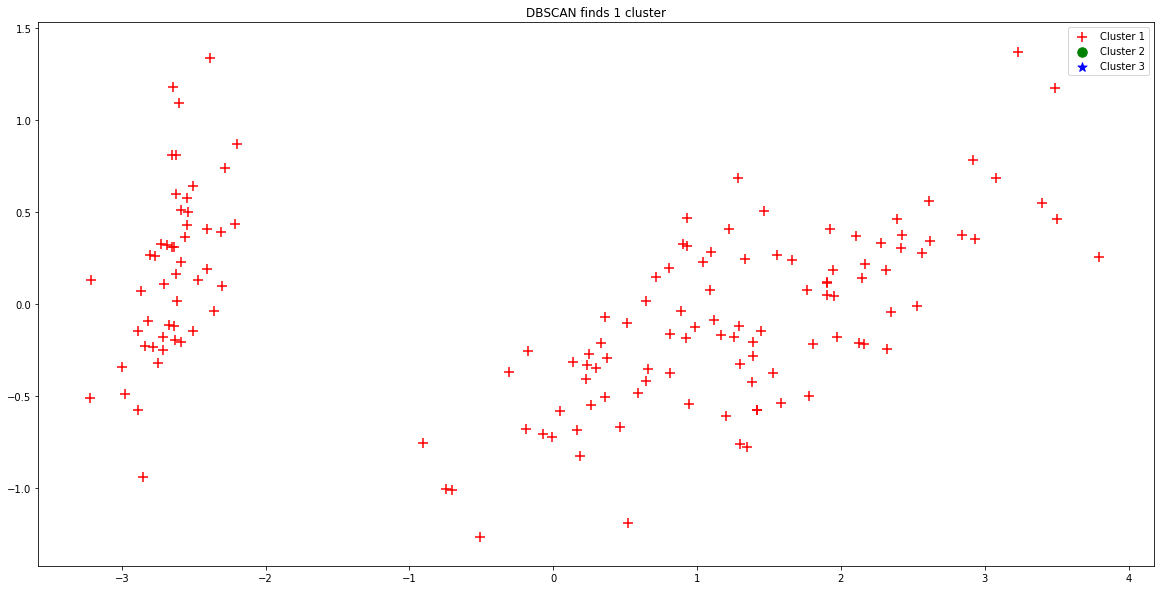

In [71]:
dbscan = DBSCAN(eps = 5, min_samples = 2)
db = dbscan.fit(Data)
pca = PCA(n_components = 2).fit(Data)
pca_2d = pca.transform(Data)
plt.figure(figsize=(20,10))

for i in range(0, pca_2d.shape[0]):
    if dbscan.labels_[i] == 0:
        c1 = plt.scatter(pca_2d[i, 0], pca_2d[i, 1], s = 90, c='r', marker='+')
    elif dbscan.labels_[i] == 1:
        c2 = plt.scatter(pca_2d[i, 0], pca_2d[i, 1], s = 90, c='g', marker='o')
    elif dbscan.labels_[i] == -1:
        c3 = plt.scatter(pca_2d[i, 0], pca_2d[i, 1], s = 90, c='b', marker='*')
        
plt.legend([c1, c2, c3], ['Cluster 1', 'Cluster 2', 'Cluster 3'])
plt.title('DBSCAN finds 1 cluster')
plt.show()

In [72]:
labels = db.labels_
print("Homogeneity: %0.3f" % metrics.homogeneity_score(Target, labels))
print("Completeness: %0.3f" % metrics.completeness_score(Target, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(Target, labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(Target, labels))
print("Adjusted Mutual Information: %0.3f"% metrics.adjusted_mutual_info_score(Target, labels))

Homogeneity: -0.000
Completeness: 1.000
V-measure: -0.000
Adjusted Rand Index: 0.000
Adjusted Mutual Information: -0.000


changing the parameters:

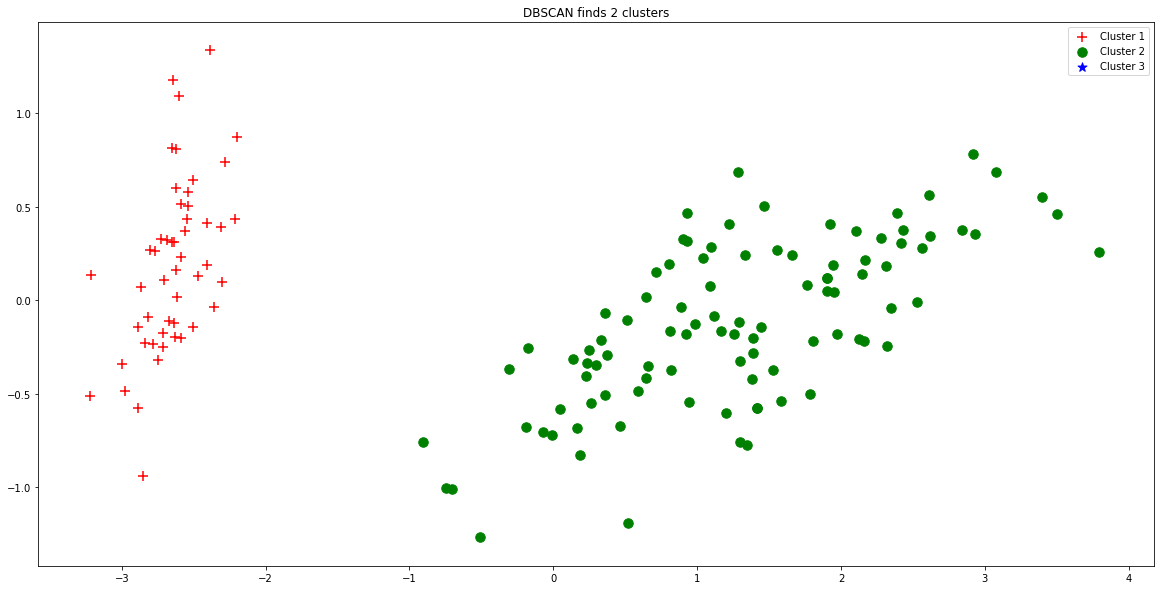

In [73]:
dbscan=DBSCAN(eps = 0.8, min_samples = 2)
db=dbscan.fit(Data)
pca=PCA(n_components = 2).fit(Data)
pca_2d=pca.transform(Data)
plt.figure(figsize=(20,10))

for i in range(0, pca_2d.shape[0]):
    if dbscan.labels_[i] == 0:
        c1 = plt.scatter(pca_2d[i, 0], pca_2d[i, 1], s = 90, c='r', marker='+')
    elif dbscan.labels_[i] == 1:
        c2 = plt.scatter(pca_2d[i, 0], pca_2d[i, 1], s = 90, c='g', marker='o')
    elif dbscan.labels_[i] == -1:
        c3 = plt.scatter(pca_2d[i, 0], pca_2d[i, 1], s = 90, c='b', marker='*')
        
plt.legend([c1, c2, c3], ['Cluster 1', 'Cluster 2', 'Cluster 3'])
plt.title('DBSCAN finds 2 clusters')
plt.show()

In [74]:
labels = db.labels_
print("Homogeneity: %0.3f" % metrics.homogeneity_score(Target, labels))
print("Completeness: %0.3f" % metrics.completeness_score(Target, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(Target, labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(Target, labels))
print("Adjusted Mutual Information: %0.3f"% metrics.adjusted_mutual_info_score(Target, labels))
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(Data, labels))

Homogeneity: 0.588
Completeness: 0.920
V-measure: 0.717
Adjusted Rand Index: 0.564
Adjusted Mutual Information: 0.713
Silhouette Coefficient: 0.512


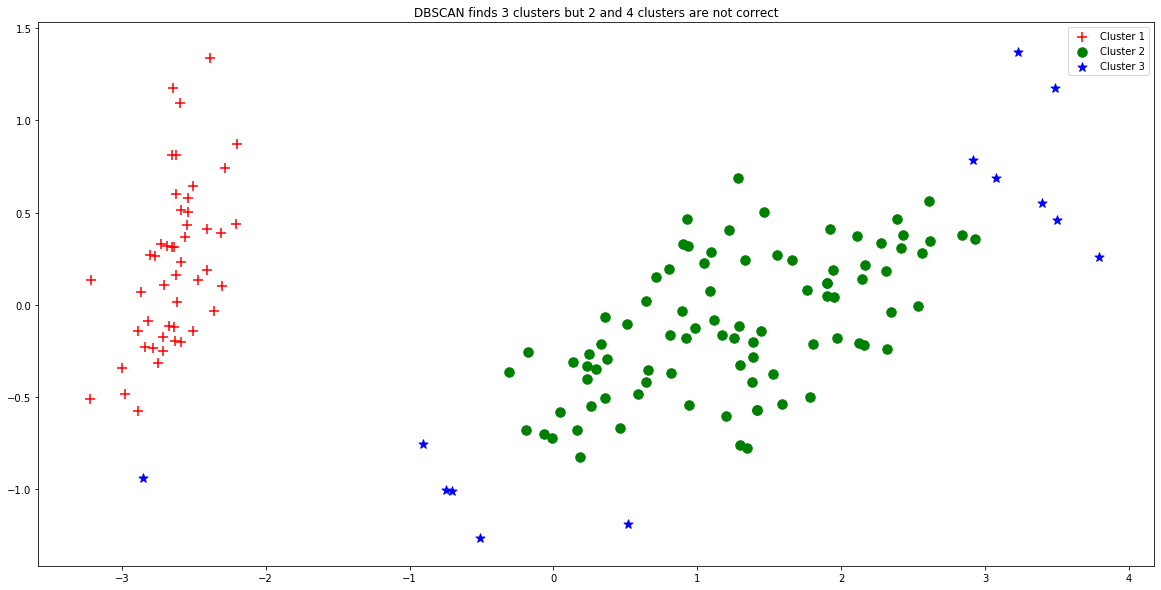

In [88]:
dbscan=DBSCAN(eps = 0.6, min_samples = 10)
db=dbscan.fit(Data)
pca=PCA(n_components = 2).fit(Data)
pca_2d=pca.transform(Data)
plt.figure(figsize=(20,10))

for i in range(0, pca_2d.shape[0]):
    if dbscan.labels_[i] == 0:
        c1 = plt.scatter(pca_2d[i, 0], pca_2d[i, 1], s = 90, c='r', marker='+')
    elif dbscan.labels_[i] == 1:
        c2 = plt.scatter(pca_2d[i, 0], pca_2d[i, 1], s = 90, c='g', marker='o')
    elif dbscan.labels_[i] == -1:
        c3 = plt.scatter(pca_2d[i, 0], pca_2d[i, 1], s = 90, c='b', marker='*')
        
plt.legend([c1, c2, c3], ['Cluster 1', 'Cluster 2', 'Cluster 3'])
plt.title('DBSCAN finds 3 clusters but 2 and 4 clusters are not correct')
plt.show()

In [89]:
labels = db.labels_
print("Homogeneity: %0.3f" % metrics.homogeneity_score(Target, labels))
print("Completeness: %0.3f" % metrics.completeness_score(Target, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(Target, labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(Target, labels))
print("Adjusted Mutual Information: %0.3f"% metrics.adjusted_mutual_info_score(Target, labels))
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(Data, labels))

Homogeneity: 0.563
Completeness: 0.694
V-measure: 0.622
Adjusted Rand Index: 0.530
Adjusted Mutual Information: 0.616
Silhouette Coefficient: 0.542


**K-Means**

First lets look at Elbow method to find optimum number of clusters

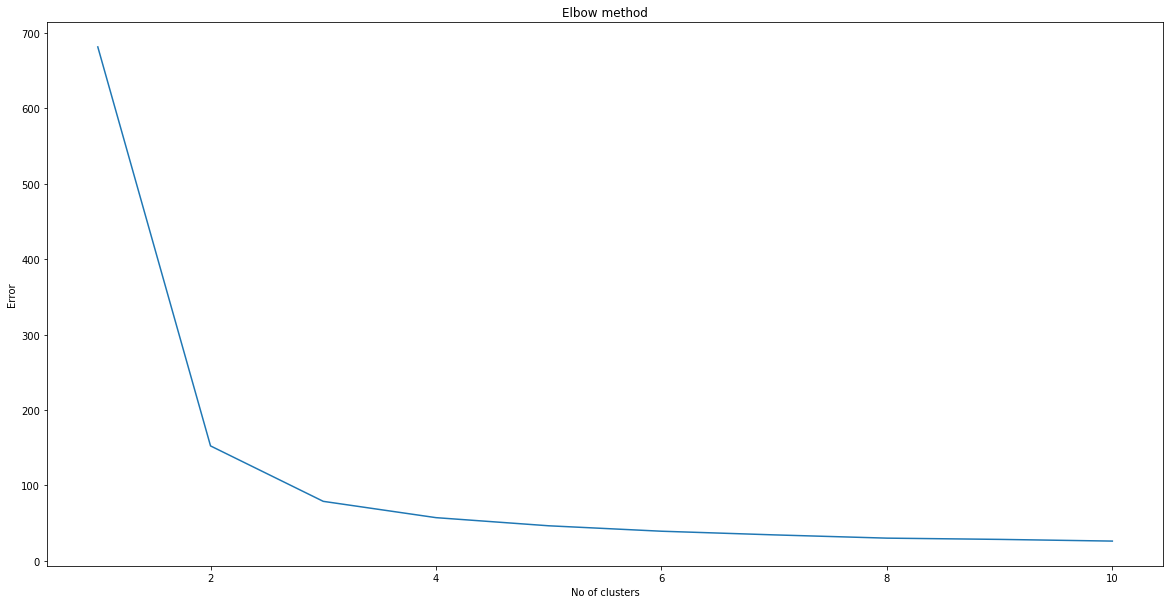

In [92]:
Error =[]
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i).fit(Data)
    kmeans.fit(Data)
    Error.append(kmeans.inertia_)

plt.figure(figsize=(20,10))
plt.plot(range(1, 11), Error)
plt.title('Elbow method')
plt.xlabel('No of clusters')
plt.ylabel('Error')
plt.show()

`It appears that 3 clusters is the optimum number`

Homogeneity: 0.751
Completeness: 0.765
V-measure: 0.758
Adjusted Rand Index: 0.730
Adjusted Mutual Information: 0.755
Silhouette Coefficient: 0.553


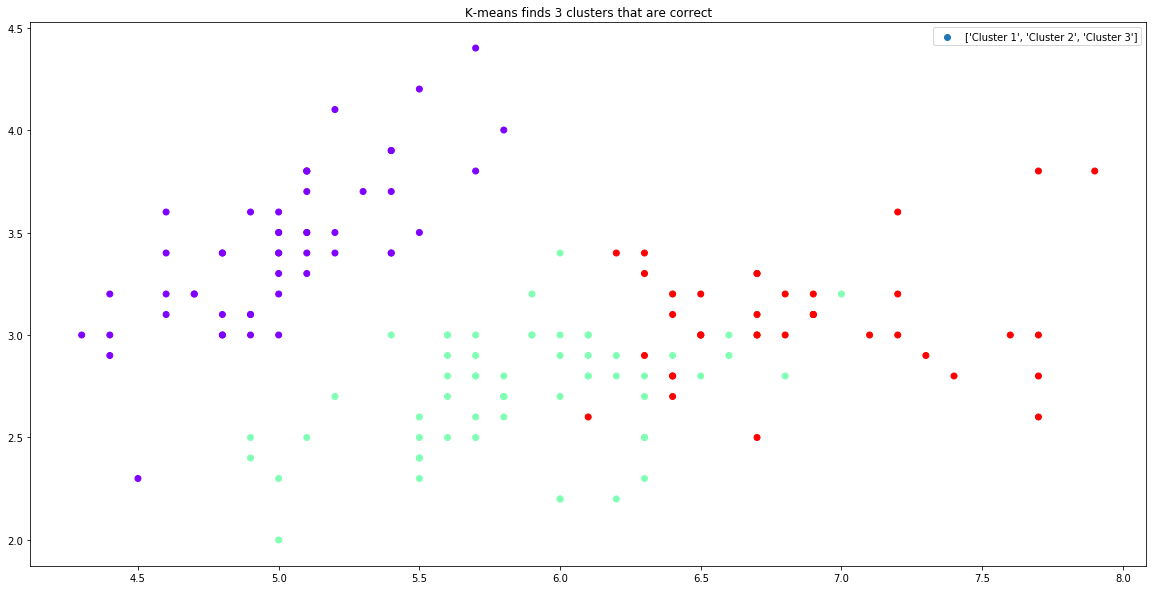

In [101]:
kmeans = KMeans(n_clusters = 3)
y_kmeans = kmeans3.fit_predict(Data)
labels = y_kmeans

plt.figure(figsize=(20,10))
plt.scatter(Data[:,0], Data[:,1], c = y_kmeans, cmap = 'rainbow',  label=['Cluster 1', 'Cluster 2', 'Cluster 3'])
plt.legend()
plt.title('K-means finds 3 clusters that are correct')

print("Homogeneity: %0.3f" % metrics.homogeneity_score(Target, labels))
print("Completeness: %0.3f" % metrics.completeness_score(Target, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(Target, labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(Target, labels))
print("Adjusted Mutual Information: %0.3f"% metrics.adjusted_mutual_info_score(Target, labels))
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(Data, labels))

**Conclusion**

DbScan is able to define the number of clusters using its two input arguement, however this does not mean that the proposed number of clusters are the most optimum. DbScab works by determining whether the minimum number of points are close enough to one another to be considered part of a single cluster. On the other hand, K_means requires the number of centroids (cluster centers) to be defiend prior to computation and to find the optimum umber of cluster we can use different indices such Sillhout index. All in all, the K-Means outpreforms DbScan in this case and is easier to optimize. 

Advantages of KMeans and DbScan:
> KMeans is much faster than DBScan  <br>
> DBScan doesn’t need number of clusters  <br>

Disadvantages of KMeans and DBScan:
> K-means need the number of clusters hidden in the dataset  <br>
DBScan doesn’t work well over clusters with different densities  <br>
DBScan needs a careful selection of its parameters  <br>

**Why is not required cross validation?**

To preform any type of cross validdation we would need some labeled data as ground truth. But in this case you could just count the number of classes in the ground truth dataset and use it as your optimal value for K, hence no-need for cross-validation. <br> 

In supervised learning, there is always a clear definition of error that quantifies how well f(X) is an approximation of y. We can then use cross validation to obtain an estimate o the out-of-sample (or generalization) error of a model. This error we can use to do mode selection. <br>

But when it comes to unsupervised learning, such as clustering, there is usually no clear definition of error. Due to this, also cross-validation cannot be used for this purpose. <br>

Alternatively there are some cluster stability measure as unsupervised performance evaluation that can be used to do some kind of cross validation procedure for that. <br>

# Extra Points ( 5pts)
Implement DBScan by using the KD-tree (you can use for the  KD-tree the implementation in scikit or Numpy). Note that the KD-tree is used for  K-nearest neighbor. 